In [89]:
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import os
import glob
import sys
import shutil
from importlib import reload
from scipy.ndimage import gaussian_filter

if 'path' in locals(): os.chdir(path)
else: os.chdir("../../../"); path = os.getcwd()
print("The path is:", path)
path_manustript = path + "/Manuscript_Results/MFI_ReInit_paper/"
path_notebook  = path_manustript + "Biasing_figures/"
path_class1D = path + "/MFI_class1D/"
path_class2D = path + "/MFI_class2D/"
path_data = path_notebook + "data/"

os.chdir(path_class1D)
# import MFI_1D_class as MFI_1D_class
import MFI_lib1D as lib1
import MFI_class1D

os.chdir(path_class2D)
import MFI_lib2D as lib2
import MFI_class2D

# Set the plotting parameters
for _plt_parameters_ in [0]:
    from matplotlib import rc
    plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["computer modern roman"], "font.size": 12})
    plw = 0.6  # width of (box line, tick line, ...)
    plt.rcParams.update({"axes.linewidth": plw, "figure.figsize": (5,4)}) 
    plt.rcParams.update({"xtick.top": True, "xtick.direction": "in", "xtick.major.width": plw, "xtick.minor.width": plw, "xtick.minor.visible": True, "xtick.major.size": 5})
    plt.rcParams.update({"ytick.right": True, "ytick.direction": "in", "ytick.major.width": plw, "ytick.minor.width": plw, "ytick.minor.visible": True, "ytick.major.size": 5})
 
# Define function to return Gaussian
def Gaus(x, mu, sigma, height): return height * np.exp(-0.5 * (x - mu)**2 / sigma**2)

The path is: /home/ucecabj/Desktop/MFI_git


In [6]:
### Reload modules
os.chdir(path_class1D); reload(MFI_class1D); reload(lib1); pass

## Biasing of 1D surface

In [17]:
# 1-D surface
n_surf = 4
[grid, y_list, y_string_list] = lib1.load_pkl(path_class1D + "fes_list_1D")
y = y_list[n_surf]
dy = np.gradient(y, grid[1] - grid[0])
y_string = y_string_list[n_surf]  
dx = grid[1] - grid[0]  

[pl_x, pl_min, pl_max, pl_n, pl_ext] = lib1.get_plumed_grid_1D(grid, -7, 7, print_info=True)

def Gaus(x, mu, sigma, height): return height * np.exp(-0.5 * (x - mu)**2 / sigma**2)

# default parameters for the MFI class 1D
default_params = {	"grid":grid, "y":y, "dy":dy, "pl_grid":pl_x, "periodic":False, "bw":dx*1.5, # "initial_position":[0,0], 
					"System":"Langevin", "cv_name":"p.x", "plumed_dat_text":f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x FUNC=({y_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n", 
					"simulation_steps": 500_000, "position_pace":50, "metad_pace":500, "n_pos_per_window":10, 
     				"metad_width":0.1, "metad_height":20, "biasfactor":80 , 
         			"Bias_sf":1.05, "gaus_filter_sigma":1, 
					"len_error_list":100, "FES_cutoff":80, 
                    "save_error_progression": False, "save_force_terms":False, "calculate_FES_st_dev":False, "bootstrap_iter":None,
     				"simulation_folder_path": path_data, "print_info": True}
                  

### Exploration stage

|**                                                | 3% | AAD: 5.32 [kJ/mol] | Time left: 0 seccc

| 100% | AAD: 5.581 [kJ/mol] | Total time: 1 sec                                                            


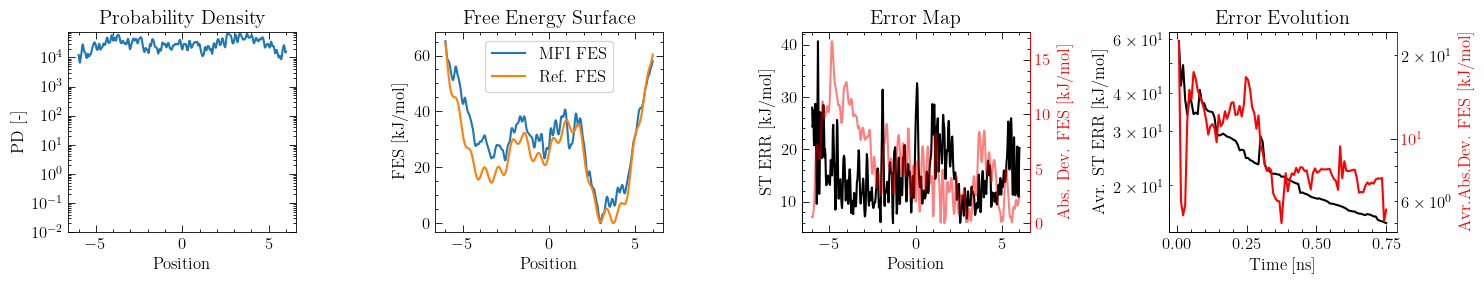

In [37]:
new_params = {**default_params}
new_params.update({"ID":"_expl", "simulation_steps": 150_000, "n_pos": 3_000})

## Load MFI object
MFI = MFI_class1D.MFI1D(**new_params)

# # MFI.run_simulation()
# # if glob.glob("bck.*"): os.system("rm bck.*")
    
MFI.analyse_data()#print_analysis=False)
t1, aofe1, aad1 = np.array(MFI.Avr_Error_list)[:,0], np.array(MFI.Avr_Error_list)[:,2], np.array(MFI.Avr_Error_list)[:,MFI.aad_index]

MFI.plot_results()
plt.show()


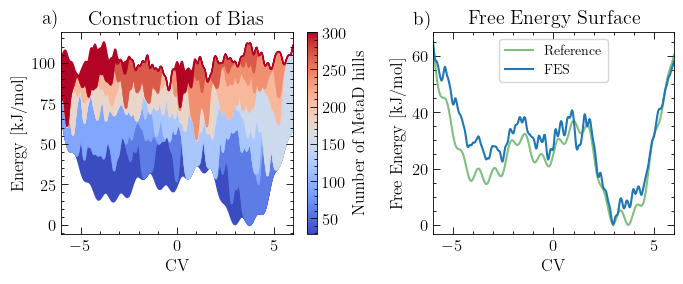

In [29]:

nhills = MFI.n_pos//MFI.n_pos_per_window
d_nhills = 30
norm = mcolors.Normalize(vmin=int(d_nhills-1), vmax=nhills)
colormap = plt.get_cmap('coolwarm')

G = np.zeros_like(grid)
G_old = np.array(y)
Gamma_factor = (MFI.hills[10, 4] - 1) / MFI.hills[10, 4] 
sigma = MFI.hills[10, 2]

fig = plt.figure(figsize=(7,3))
gs = gridspec.GridSpec(1, 2, width_ratios=[1.2, 1])
ax1 = plt.subplot(gs[0])

for i in range(0, nhills):
	G += Gaus(grid, MFI.hills[i,1], sigma, MFI.hills[i,3] * Gamma_factor)
	if (i+1) % d_nhills == 0:
		plt.fill_between(grid, G_old, G_old + G, color=colormap(norm(i)))
		G_old += G
		G = np.zeros_like(grid)    
		
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm); sm.set_array([]); cbar = plt.colorbar(sm, ax=ax1); cbar.set_label('Number of MetaD hills')
plt.title("Construction of Bias"); plt.xlabel("CV"); plt.ylabel("Energy [kJ/mol]"); plt.xlim(-6,6); #plt.legend()

ax2 = plt.subplot(gs[1])
plt.plot(grid, y, label="Reference", color="green", alpha=0.5)
plt.plot(grid, MFI.FES, label="FES")
plt.title("Free Energy Surface"); plt.xlabel("CV"); plt.ylabel("Free Energy [kJ/mol]"); plt.xlim(-6,6); plt.legend(fontsize=10, loc="upper center"); plt.tight_layout()

ax1.text(-7, 124, "a)" , fontsize=14)	
ax2.text(-7, 71, "b)" , fontsize=14)	

# plt.savefig(path_notebook + "exploration.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

### MetaD stage

| 100% | AAD: 1.154 [kJ/mol] | Total time: 1 sec                                                            
MFI2.AAD = 1.154


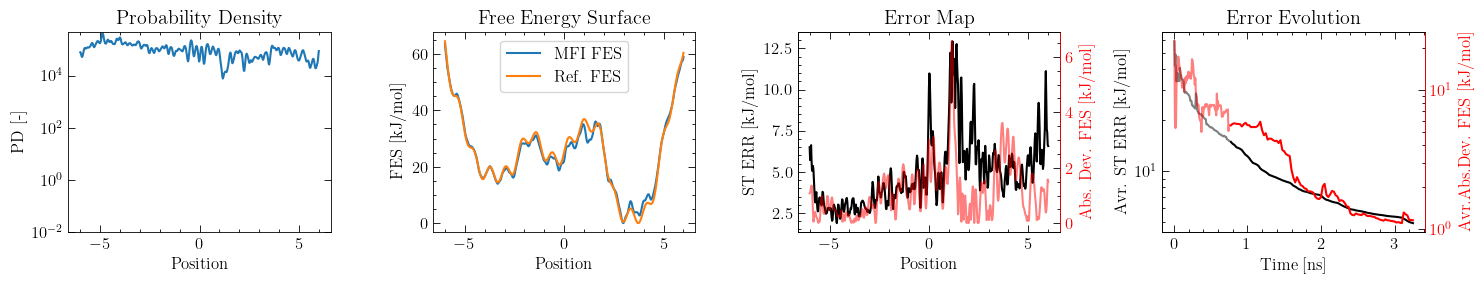

In [63]:
# definde new parameters 
new_params = {**default_params}
new_params.update({"ID":"_MetaD", "simulation_steps": 500_000, "metad_height":3, "biasfactor":10, "metad_width":0.1})
new_params.update({"base_forces":MFI.force_terms, "base_time": MFI.sim_time, "metad_height":5, "biasfactor":10, })

MFI2 = MFI_class1D.MFI1D(**new_params)

MFI2.make_external_bias(FES=MFI.FES, Bias_sf=1, gaus_filter_sigma=1, FES_cutoff=MFI.FES_cutoff)

# MFI2.run_simulation()
# if glob.glob("bck.*"): os.system("rm bck.*")
    
MFI2.analyse_data()#print_analysis=False)
print(f"{MFI2.AAD = :.3f}")
t2, aofe2, aad2 = MFI2.Avr_Error_list[:,0], MFI2.Avr_Error_list[:,2], MFI2.Avr_Error_list[:,MFI2.aad_index]
MFI2.plot_results(more_aofe=[t1, aofe1] , more_aad = [t1, aad1])

for _plot_ in [1]:
    # plt.figure(figsize=(15,3))
    # plt.subplot(1,2,1)
    # plt.plot(grid, MFI2.FES, label="FES")
    # plt.plot(grid, y, label="Analytical", color="grey", alpha=0.3)
    # plt.fill_between(grid, y, y + MFI2.Bias_static, alpha=0.3, label="Static")
    # plt.fill_between(grid, y + MFI2.Bias_static, y + MFI2.Bias_static + MFI2.Bias, alpha=0.7, color="green", label="MetaD")
    # plt.title("FES and Bias"); plt.xlabel("CV"); plt.ylabel("Energy"); plt.legend()

    # plt.subplot(1,2,2)
    # plt.scatter(MFI2.hills[:,0], MFI2.hills[:,1], facecolors='none', edgecolors='blue', label="Hills")
    # plt.scatter(MFI2.position[:,0], MFI2.position[:,1], facecolors='none', edgecolors='red', alpha=0.2, label="Position", s=1)
    # plt.title("Trajectory"); plt.xlabel("time"); plt.ylabel("CV")
    pass



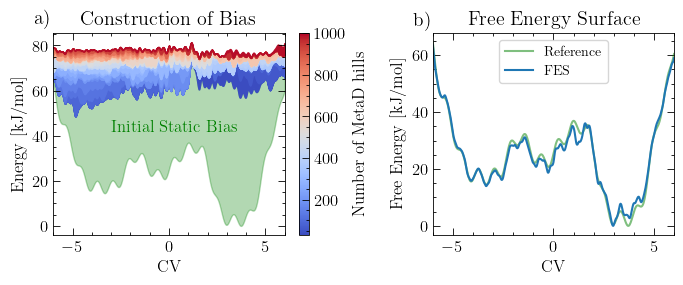

In [58]:
nhills = MFI2.n_pos//MFI2.n_pos_per_window
d_nhills = 30
norm = mcolors.Normalize(vmin=int(d_nhills-1), vmax=nhills)
colormap = plt.get_cmap('coolwarm')

G = np.zeros_like(grid)
G_old = np.array(y) + MFI2.Bias_static
Gamma_factor = (MFI2.hills[10, 4] - 1) / MFI2.hills[10, 4] 
sigma = MFI2.hills[10, 2]

fig = plt.figure(figsize=(7,3))
gs = gridspec.GridSpec(1, 2, width_ratios=[1.2, 1])
ax1 = plt.subplot(gs[0])

plt.fill_between(grid, y, y + MFI2.Bias_static, alpha=0.3, label="Static", color="green")
for i in range(0, nhills):
	G += Gaus(grid, MFI2.hills[i,1], sigma, MFI2.hills[i,3] * Gamma_factor)
	if (i+1) % d_nhills == 0:
		plt.fill_between(grid, G_old, G_old + G, color=colormap(norm(i)))
		G_old += G
		G = np.zeros_like(grid)    
		
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm); sm.set_array([]); cbar = plt.colorbar(sm, ax=ax1); cbar.set_label('Number of MetaD hills')
plt.title("Construction of Bias"); plt.xlabel("CV"); plt.ylabel("Energy [kJ/mol]"); plt.xlim(-6,6); #plt.legend()
plt.text(-3, 42, "Initial Static Bias", fontweight="heavy", fontsize=12, color="green")

ax2 = plt.subplot(gs[1])
plt.plot(grid, y, label="Reference", color="green", alpha=0.5)
plt.plot(grid, MFI2.FES, label="FES")
plt.title("Free Energy Surface"); plt.xlabel("CV"); plt.ylabel("Free Energy [kJ/mol]"); plt.legend(fontsize=10, loc="upper center"); plt.xlim(-6,6); plt.tight_layout()

ax1.text(-7, 89.5, "a)" , fontsize=14)	
ax2.text(-7, 70.5, "b)" , fontsize=14)	

# plt.savefig(path_notebook + "MetaD.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

### Flat Bias stage


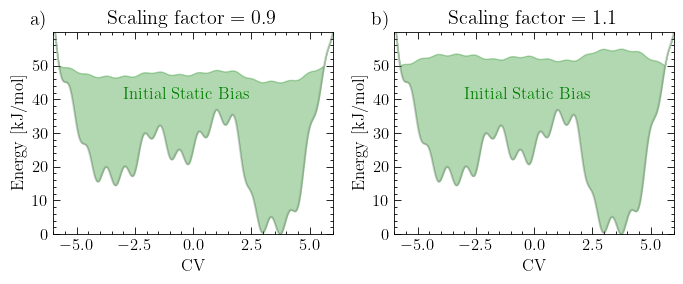

In [59]:

fcut = 50
Bias1, Fbias1, _ = lib1.make_external_bias_1D(grid, FES=y, Bias_sf=1, gaus_filter_sigma=0, FES_cutoff=fcut, pl_min=pl_min, pl_max=pl_max, return_array=True)
Bias2, Fbias2, _ = lib1.make_external_bias_1D(grid, FES=y, Bias_sf=1, gaus_filter_sigma=0, FES_cutoff=fcut, pl_min=pl_min, pl_max=pl_max, return_array=True)

Bias1 = Bias1*(0.9)
Bias2 = Bias2*(1.1)

plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.plot(grid, y, label="Analytical", color="grey", alpha=0.3)
plt.fill_between(grid, y, y + Bias1, alpha=0.3, label="Static", color="green")
plt.title("Scaling factor = 0.9"); plt.xlabel("CV"); plt.ylabel("Energy [kJ/mol]"); plt.ylim(0,fcut+9.9); plt.xlim(-6,6); #plt.legend()
plt.text(-3, 40, "Initial Static Bias", fontweight="heavy", fontsize=12, color="green")

plt.subplot(1,2,2)
plt.plot(grid, y, label="Analytical", color="grey", alpha=0.3)
plt.fill_between(grid, y, y + Bias2, alpha=0.3, label="Static", color="green")
plt.title("Scaling factor = 1.1"); plt.xlabel("CV"); plt.ylabel("Energy [kJ/mol]"); plt.ylim(0,fcut+9.9); plt.xlim(-6,6); #plt.legend()
plt.tight_layout()
plt.text(-3, 40, "Initial Static Bias", fontweight="heavy", fontsize=12, color="green")


plt.subplot(1,2,1); plt.text(-7, 62, "a)" , fontsize=14)	
plt.subplot(1,2,2); plt.text(-7, 62, "b)" , fontsize=14)	

# plt.savefig(path_notebook + "InvF_scaling.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

| 100% | AAD: 0.685 [kJ/mol] | Total time: 1 sec                                                            


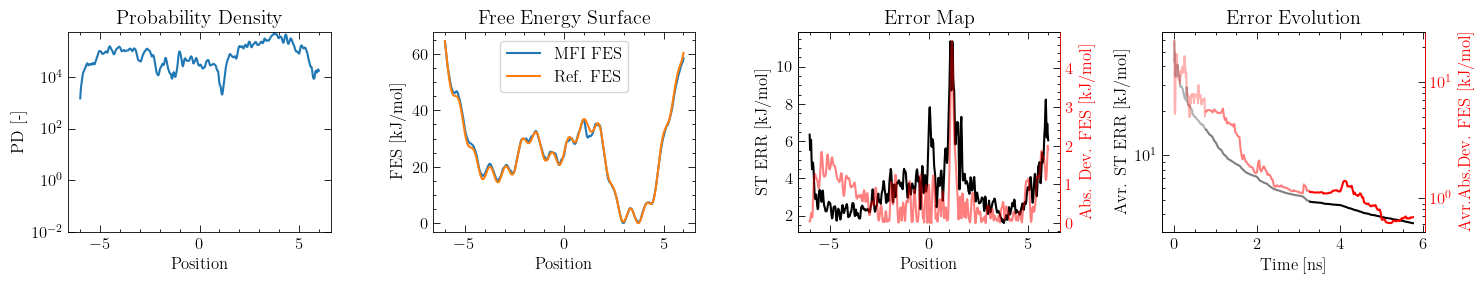

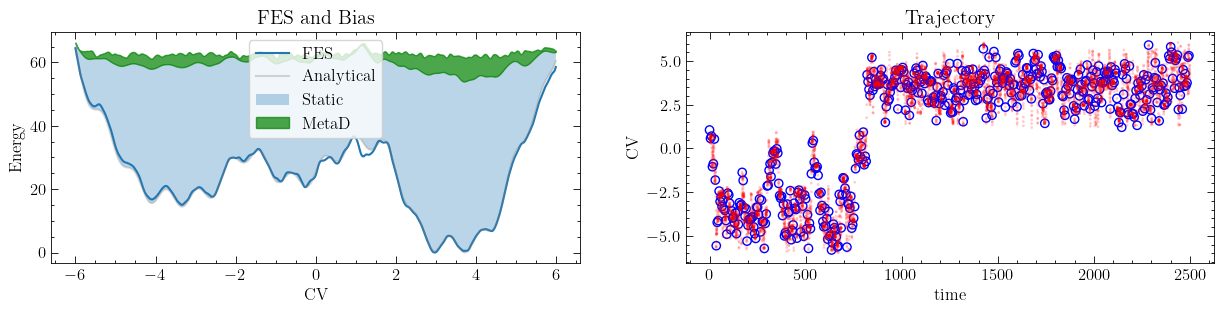

In [64]:
# definde new parameters 
new_params = {**default_params}
new_params.update({"ID":"_3", "simulation_steps": 500_000, "metad_height":1, "biasfactor":5, "metad_width":0.05})
new_params.update({"metad_pace":1000, "position_pace": 50, "n_pos_per_window":20})
new_params.update({"base_forces":lib1.patch_forces(MFI.force_terms, MFI2.force_terms), "base_time": MFI.sim_time + MFI2.sim_time})

MFI3 = MFI_class1D.MFI1D(**new_params)

MFI3.make_external_bias(MFI2.FES, Bias_sf=0.9, gaus_filter_sigma=3, FES_cutoff=max(MFI2.FES))

# MFI3.run_simulation()
	
MFI3.analyse_data()

MFI3.plot_results(more_aofe=[[t1, aofe1], [t2, aofe2]] , more_aad = [[t1, aad1], [t2, aad2]])
t3, aofe3, aad3 = MFI3.Avr_Error_list[:,0], MFI3.Avr_Error_list[:,2], MFI3.Avr_Error_list[:,MFI3.aad_index]

for _plot_ in [1]:
    plt.figure(figsize=(15,3))
    plt.subplot(1,2,1)
    plt.plot(grid, MFI3.FES, label="FES")
    plt.plot(grid, y, label="Analytical", color="grey", alpha=0.3)
    plt.fill_between(grid, y, y + MFI3.Bias_static, alpha=0.3, label="Static")
    plt.fill_between(grid, y + MFI3.Bias_static, y + MFI3.Bias_static + MFI3.Bias, alpha=0.7, color="green", label="MetaD")
    plt.title("FES and Bias"); plt.xlabel("CV"); plt.ylabel("Energy"); plt.legend()

    plt.subplot(1,2,2)
    plt.scatter(MFI3.hills[:,0], MFI3.hills[:,1], facecolors='none', edgecolors='blue', label="Hills")
    plt.scatter(MFI3.position[:,0], MFI3.position[:,1], facecolors='none', edgecolors='red', alpha=0.2, label="Position", s=1)
    plt.title("Trajectory"); plt.xlabel("time"); plt.ylabel("CV")


###  US stage

In [65]:
### Reload modules
os.chdir(path_class1D); reload(MFI_class1D); reload(lib1); pass

| 100% | AAD: 0.524 [kJ/mol] | Total time: 1 sec                                                            
MFI4.AAD = 0.524


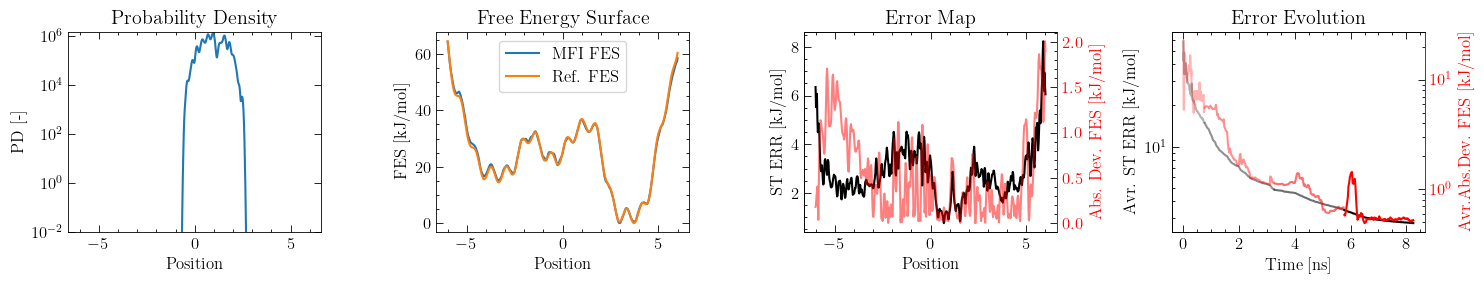

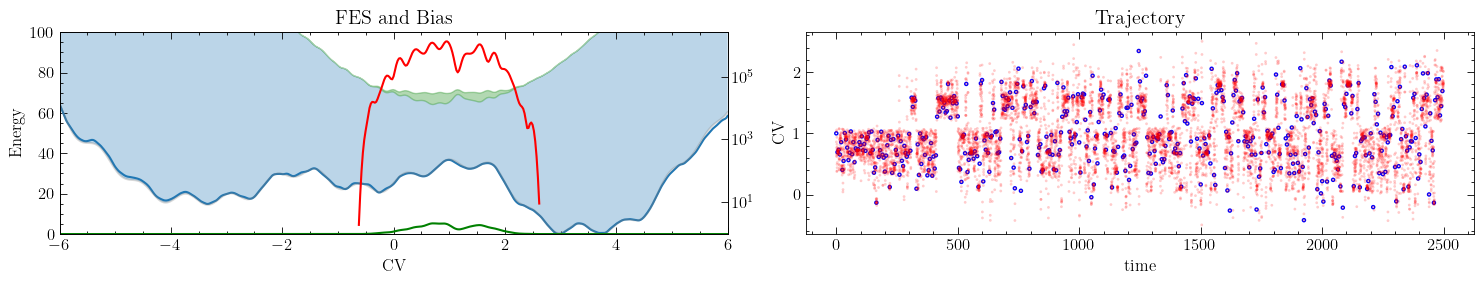

In [74]:
# definde new parameters 
new_params = {**default_params}
new_params.update({"ID":"_4", "simulation_steps": 500_000, "metad_height":0.1, "biasfactor":5, "metad_width":0.1})
new_params.update({"metad_pace":1000, "position_pace": 50, "n_pos_per_window":20})
new_params.update({"hp_centre":1, "hp_kappa": 10, "initial_position":1})
new_params.update({"base_forces":lib1.patch_forces([MFI.force_terms, MFI2.force_terms, MFI3.force_terms]), "base_time": MFI.sim_time + MFI2.sim_time + MFI3.sim_time})

MFI4 = MFI_class1D.MFI1D(**new_params)

MFI4.make_external_bias(MFI3.FES, Bias_sf=1, gaus_filter_sigma=None, FES_cutoff=max(MFI3.FES))

# MFI4.run_simulation()
	
MFI4.analyse_data()#print_analysis=False)

print(f"{MFI4.AAD = :.3f}")
MFI4.plot_results(more_aofe=[[t1, aofe1], [t2, aofe2], [t3, aofe3]] , more_aad = [[t1, aad1], [t2, aad2], [t3, aad3]])
t4, aofe4, aad4 = MFI4.Avr_Error_list[:,0], MFI4.Avr_Error_list[:,2], MFI4.Avr_Error_list[:,MFI4.aad_index]

for _plot_ in [1]:
    plt.figure(figsize=(15,3))
    ax1 = plt.subplot(1,2,1)
    ax1.plot(grid, MFI4.FES, label="FES")
    ax1.plot(grid, y, label="Analytical", color="grey", alpha=0.3)
    ax1.fill_between(grid, y, y + MFI4.Bias_static, alpha=0.3, label="Static")
    ax1.fill_between(grid, y + MFI4.Bias_static, y + MFI4.Bias_static + MFI4.Bias, alpha=0.3, color="green", label="MetaD")
    ax1.plot(grid, MFI4.Bias , color="green", label="Bias")
    ax1.set_title("FES and Bias"); ax1.set_xlabel("CV"); ax1.set_ylabel("Energy"); ax1.set_ylim(0, 100); ax1.set_xlim(-6, 6);
    # plt.legend()

    ax2 = ax1.twinx()

    # ax1.plt.plot(grid, np.where(MFI4.PD > 0.1, np.log(MFI4.PD), None), color="red", label="PD")
    ax2.plot(grid, np.where(MFI4.PD > 1, (MFI4.PD), None), color="red", label="PD")
    ax2.set_yscale("log")

    plt.subplot(1,2,2)
    plt.scatter(MFI4.hills[:,0], MFI4.hills[:,1], facecolors='none', edgecolors='blue', label="Hills", s=5)
    plt.scatter(MFI4.position[:,0], MFI4.position[:,1], facecolors='none', edgecolors='red', alpha=0.2, label="Position", s=1)
    plt.title("Trajectory"); plt.xlabel("time"); plt.ylabel("CV")

    plt.tight_layout(); plt.show()



| 100% | AAD: 0.47 [kJ/mol] | Total time: 1 sec                                                            
MFI42.AAD = 0.470


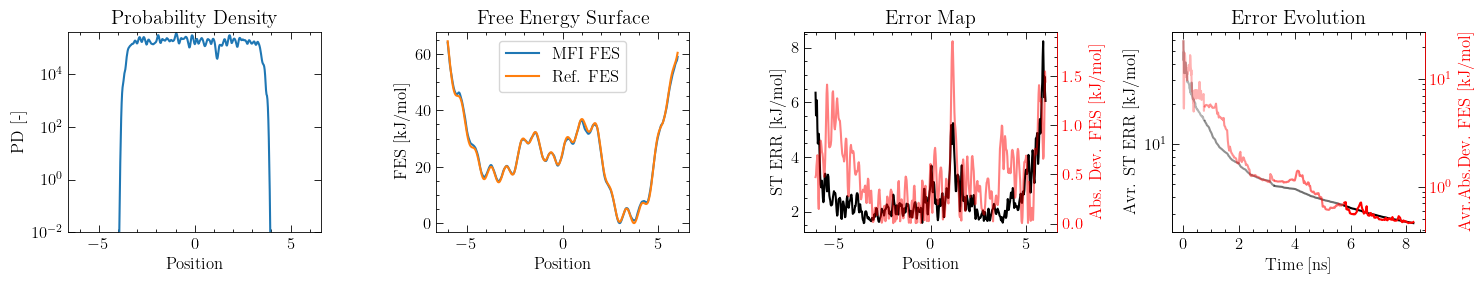

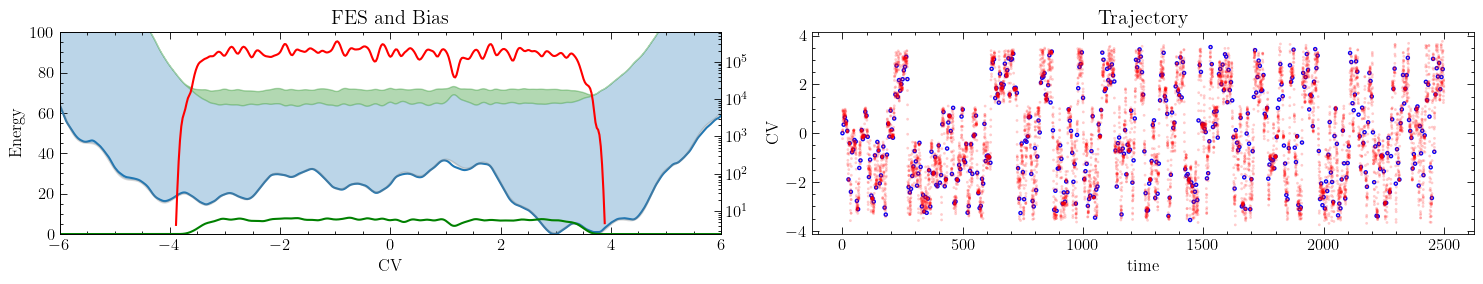

In [70]:
# definde new parameters 
new_params = {**default_params}
new_params.update({"ID":"_42", "simulation_steps": 500_000, "metad_height":1, "biasfactor":5, "metad_width":0.1})
new_params.update({"metad_pace":1000, "position_pace": 50, "n_pos_per_window":20})
new_params.update({"base_forces":lib1.patch_forces([MFI.force_terms, MFI2.force_terms, MFI3.force_terms]), "base_time": MFI.sim_time + MFI2.sim_time + MFI3.sim_time})

new_params.update({"lw_centre":-3, "lw_kappa": 20, "uw_centre":3, "uw_kappa": 20, "initial_position":0})

MFI42 = MFI_class1D.MFI1D(**new_params)

MFI42.make_external_bias(MFI3.FES, Bias_sf=1, gaus_filter_sigma=None, FES_cutoff=max(MFI3.FES))

# MFI42.run_simulation()
	
MFI42.analyse_data()#print_analysis=False)

print(f"{MFI42.AAD = :.3f}")
MFI42.plot_results(more_aofe=[[t1, aofe1], [t2, aofe2], [t3, aofe3]] , more_aad = [[t1, aad1], [t2, aad2], [t3, aad3]])

for _plot_ in [1]:
    plt.figure(figsize=(15,3))
    ax1 = plt.subplot(1,2,1)
    ax1.plot(grid, MFI42.FES, label="FES")
    ax1.plot(grid, y, label="Analytical", color="grey", alpha=0.3)
    ax1.fill_between(grid, y, y + MFI42.Bias_static, alpha=0.3, label="Static")
    ax1.fill_between(grid, y + MFI42.Bias_static, y + MFI42.Bias_static + MFI42.Bias, alpha=0.3, color="green", label="MetaD")
    ax1.plot(grid, MFI42.Bias , color="green", label="Bias")
    ax1.set_title("FES and Bias"); ax1.set_xlabel("CV"); ax1.set_ylabel("Energy"); ax1.set_ylim(0, 100); ax1.set_xlim(-6, 6);
    # plt.legend()

    ax2 = ax1.twinx()

    # ax1.plt.plot(grid, np.where(MFI4.PD > 0.1, np.log(MFI4.PD), None), color="red", label="PD")
    ax2.plot(grid, np.where(MFI42.PD > 1, (MFI42.PD), None), color="red", label="PD")
    ax2.set_yscale("log")

    plt.subplot(1,2,2)
    plt.scatter(MFI42.hills[:,0], MFI42.hills[:,1], facecolors='none', edgecolors='blue', label="Hills", s=5)
    plt.scatter(MFI42.position[:,0], MFI42.position[:,1], facecolors='none', edgecolors='red', alpha=0.2, label="Position", s=1)
    plt.title("Trajectory"); plt.xlabel("time"); plt.ylabel("CV")

    plt.tight_layout(); plt.show()



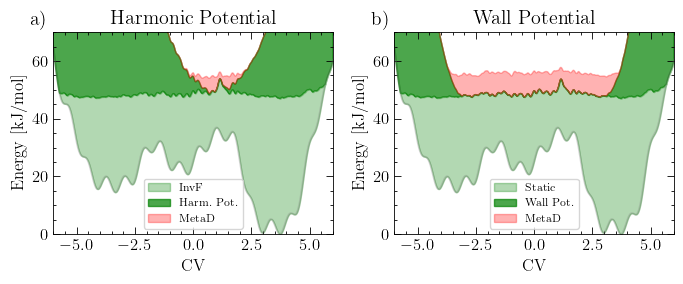

In [72]:
fcut = 50
Bias, Fbias, _ = lib1.make_external_bias_1D(grid, FES=MFI3.FES, Bias_sf=0.95, gaus_filter_sigma=0, FES_cutoff=fcut, pl_min=pl_min, pl_max=pl_max, return_array=True)

hp_centre, hp_kappa = 1, 10
lw_centre, lw_kappa, uw_centre, uw_kappa = -3, 20, 3, 20

HP_bias = hp_kappa / 2 * (grid - hp_centre)**2
LW_bias = np.where(grid < lw_centre, lw_kappa * (grid - lw_centre)**2, 0.0)
UW_bias = np.where(grid > uw_centre, uw_kappa * (grid - uw_centre)**2, 0.0)

plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.plot(grid, y, color="grey", alpha=0.3)
plt.fill_between(grid, y, y + Bias, alpha=0.3, label="InvF", color="green")
plt.fill_between(grid, y + Bias, y + Bias + HP_bias, alpha=0.7, label="Harm. Pot.", color="green")
plt.fill_between(grid, y + Bias + HP_bias, y + Bias + HP_bias + MFI4.Bias, alpha=0.3, color="red", label="MetaD")
plt.title("Harmonic Potential"); plt.xlabel("CV"); plt.ylabel("Energy [kJ/mol]"); plt.ylim(0,fcut+20); plt.xlim(-6,6); plt.legend(fontsize=8, loc="lower center")

plt.subplot(1,2,2)
plt.plot(grid, y, color="grey", alpha=0.3)
plt.fill_between(grid, y, y + Bias, alpha=0.3, label="Static", color="green")
plt.fill_between(grid, y + Bias, y + Bias + LW_bias + UW_bias, alpha=0.7, label="Wall Pot.", color="green")
plt.fill_between(grid, y + Bias + LW_bias + UW_bias, y + Bias + LW_bias + UW_bias + MFI42.Bias, alpha=0.3, color="red", label="MetaD")
plt.title("Wall Potential"); plt.xlabel("CV"); plt.ylabel("Energy [kJ/mol]"); plt.ylim(0,fcut+20); plt.xlim(-6,6); plt.legend(fontsize=8, loc="lower center")
plt.tight_layout()

# plot text" "a)" in top left corner
plt.subplot(1,2,1); plt.text(-7, 72.5, "a)" , fontsize=14)	
plt.subplot(1,2,2); plt.text(-7, 72.5, "b)" , fontsize=14)	
# plt.text()

# plt.savefig(path_notebook + "US_stage.png", dpi=300, bbox_inches="tight", transparent=True)

plt.show()

### Error based sampling stage

| 100% | AAD: 0.404 [kJ/mol] | Total time: 1 sec                                                            
MFI5.AAD = 0.404


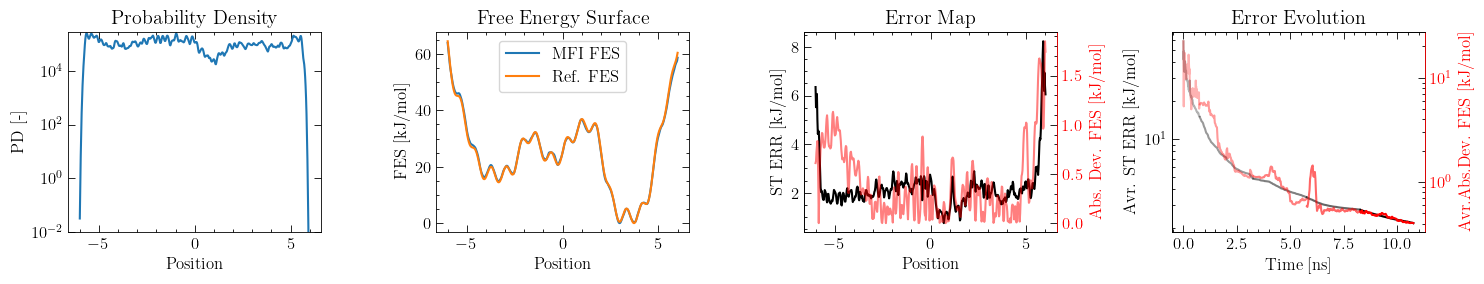

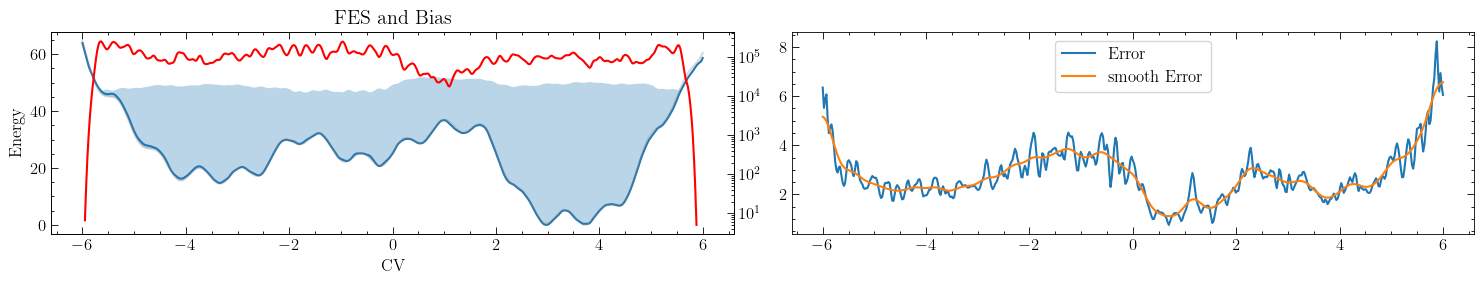

In [75]:
# definde new parameters 
new_params = {**default_params}
new_params.update({"ID":"_5", "simulation_steps": 500_000, "metad_height":0.5, "biasfactor":5, "metad_width":0.1})
new_params.update({"metad_pace":1000, "position_pace": 50, "n_pos_per_window":20})
new_params.update({"base_forces":lib1.patch_forces([MFI.force_terms, MFI2.force_terms, MFI3.force_terms, MFI4.force_terms]), "base_time": MFI.sim_time + MFI2.sim_time + MFI3.sim_time + MFI4.sim_time})

MFI5 = MFI_class1D.MFI1D(**new_params)

MFI5.make_external_bias(MFI4.FES, Bias_sf=1, gaus_filter_sigma=None, FES_cutoff=fcut, bias_type="error", error=MFI4.ofe)

# MFI5.run_simulation()
	
MFI5.analyse_data()#print_analysis=False)

print(f"{MFI5.AAD = :.3f}")
MFI5.plot_results(more_aofe=[[t1, aofe1], [t2, aofe2], [t3, aofe3], [t4, aofe4]] , more_aad = [[t1, aad1], [t2, aad2], [t3, aad3], [t4, aad4]])

for _plot_ in [1]:
    plt.figure(figsize=(15,3))
    ax1 = plt.subplot(1,2,1)
    ax1.plot(grid, MFI5.FES, label="FES")
    ax1.plot(grid, y, label="Analytical", color="grey", alpha=0.3)
    ax1.fill_between(grid, y, y + MFI5.Bias_static, alpha=0.3, label="Static")
    # ax1.fill_between(grid, y + MFI5.Bias_static, y + MFI5.Bias_static + MFI5.Bias, alpha=0.3, color="green", label="MetaD")
    ax1.set_title("FES and Bias"); ax1.set_xlabel("CV"); ax1.set_ylabel("Energy");# plt.legend()

    ax2 = ax1.twinx()

    # ax1.plt.plot(grid, np.where(MFI4.PD > 0.1, np.log(MFI4.PD), None), color="red", label="PD")
    ax2.plot(grid, np.where(MFI5.PD > 1, (MFI5.PD), None), color="red", label="PD")
    ax2.set_yscale("log")

    plt.subplot(1,2,2)
    # plt.scatter(MFI5.hills[:,0], MFI5.hills[:,1], facecolors='none', edgecolors='blue', label="Hills", s=5)
    # plt.scatter(MFI5.position[:,0], MFI5.position[:,1], facecolors='none', edgecolors='red', alpha=0.2, label="Position", s=1)
    # plt.title("Trajectory"); plt.xlabel("time"); plt.ylabel("CV")
    plt.plot(grid, MFI4.ofe, label="Error")
    plt.plot(grid, gaussian_filter(MFI4.ofe, 6), label="smooth Error"); plt.legend()
    plt.tight_layout(); plt.show()



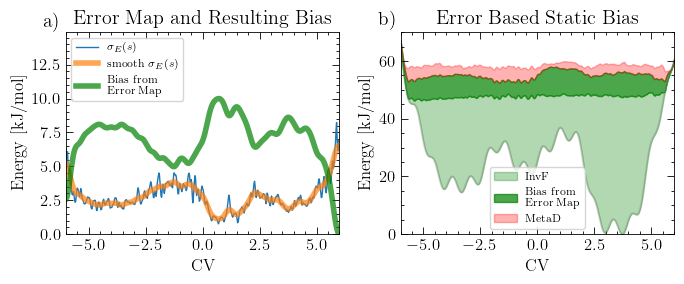

In [76]:
fcut = 50
Bias, Fbias, _ = lib1.make_external_bias_1D(grid, FES=MFI4.FES, Bias_sf=1, gaus_filter_sigma=0, 
                                            FES_cutoff=fcut-2, 
                                            pl_min=pl_min, pl_max=pl_max, return_array=True)

plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.plot(grid, MFI4.ofe, label=r"$\sigma_E(s)$", linewidth=1)
plt.plot(grid, gaussian_filter(MFI4.ofe, 6), label=r"smooth $\sigma_E(s)$", linewidth=4, alpha=0.7)
plt.title("Error Map and Resulting Bias"); plt.xlabel("CV"); plt.ylabel("Energy [kJ/mol]"); #plt.ylim(0,fcut+20); 
plt.xlim(-6,6); 

error_bias = MFI4.ofe
error_bias = gaussian_filter(error_bias, 6)
error_bias = -error_bias - np.min(-error_bias)
error_bias = error_bias * 10 / np.max(error_bias) 
error_bias = error_bias - np.min(error_bias)

plt.plot(grid, error_bias, label="Bias from\nError Map", linewidth=4, alpha=0.7, color="green")
plt.ylim(0,14.9)
plt.legend(fontsize=8, loc="upper left")


plt.subplot(1,2,2)
plt.plot(grid, y, color="grey", alpha=0.3)
plt.fill_between(grid, y, y + Bias, alpha=0.3, label="InvF", color="green")
plt.fill_between(grid, y + Bias, y + Bias + error_bias, alpha=0.7, label="Bias from\nError Map", color="green")
plt.fill_between(grid, y + Bias + error_bias, y + Bias + error_bias + MFI5.Bias, alpha=0.3, color="red", label="MetaD")
plt.title("Error Based Static Bias"); plt.xlabel("CV"); plt.ylabel("Energy [kJ/mol]"); plt.ylim(0,fcut+20); plt.xlim(-6,6); plt.legend(fontsize=8, loc="lower center")
plt.tight_layout()

# plot text" "a)" in top left corner
plt.subplot(1,2,1); plt.text(-7, 15.3, "a)" , fontsize=14)	
plt.subplot(1,2,2); plt.text(-7, 72.5, "b)" , fontsize=14)	
# plt.text()

# plt.savefig(path_notebook + "error_stage.png", dpi=300, bbox_inches="tight", transparent=True)

plt.show()

### Plot

In [78]:
def make_nice_figure(*MFI_instances, save_path=None, t_range=None, aofe_range=None, aad_range=None, end_exploration=None, end_metad=None, end_flat=None, plot_show=True):
        
    if len(MFI_instances) > 0: MFI_plot, plot_MFI = MFI_instances[-1], True
    else: plot_MFI = False

    ### --- Plot FES and surface ------------ ###
    plt.figure(figsize=(6,6))
    plt.subplot(2,2,1)
    if "y" in locals(): plt.plot(grid, y, label="Analytical", color="grey", alpha=0.3)
    plt.title("FES and Bias"); plt.xlabel("s"); plt.ylabel("Energy [kJ/mol]")
    
    if plot_MFI: 
        plt.plot(grid, MFI_plot.FES, label="cyan")
        plt.fill_between(grid, y , y + MFI_plot.Bias_static, alpha=0.3, color="red", label="MetaD")
        plt.fill_between(grid, y + MFI_plot.Bias_static, y + MFI_plot.Bias_static + MFI_plot.Bias, alpha=0.3, color="orange", label="MetaD")
    # plt.legend(fontsize=10)

    ### --- Plot error map ------------ ###
    ax3 = plt.subplot(2,2,2)
    ax3_2 = ax3.twinx()
    
    if plot_MFI: 
        ax3.plot(MFI_plot.grid, MFI_plot.ofe, color="black")
        ax3_2.plot(MFI_plot.grid, MFI_plot.AD, color="red", alpha=0.5)
    
    ax3.set_title("Error Map"); ax3.set_xlabel("s"); ax3.set_ylabel("$\sigma$(Force) [kJ/mol]")
    ax3_2.set_ylabel("AD. FES [kJ/mol]", color="red")
    ax3_2.tick_params(axis='y', labelcolor="red"); ax3_2.spines['right'].set_color('red')
    ax3.set_yscale("symlog", linthresh=0.1)
    ax3.set_ylim(0, 100)
    ax3_2.set_yscale("symlog", linthresh=0.01)
    ax3_2.set_ylim(0, 100)

    ### --- Plot error progression ------------ ###
    ax4 = plt.subplot(2,1,2)
    ax4_2 = ax4.twinx()
    
    if plot_MFI: 
        
        if t_range is None: 
            t_min, t_max = 1E6, 0
            for i in range(len(MFI_instances)): t_max, t_min = max(t_max, np.max(MFI_instances[i].Avr_Error_list[:,0])), min(t_min, np.min(MFI_instances[i].Avr_Error_list[:,0]))
            t_min, t_max = t_min*0.9, t_max*1.1
        else: t_min, t_max = t_range
        if aofe_range is None:
            aofe_min, aofe_max = 1E6, 0
            for i in range(len(MFI_instances)): aofe_max, aofe_min = max(aofe_max, np.max(MFI_instances[i].Avr_Error_list[:,2])), min(aofe_min, np.min(MFI_instances[i].Avr_Error_list[:,2]))
            aofe_min, aofe_max = aofe_min*0.9, aofe_max*1.1
        else: aofe_min, aofe_max = aofe_range
        if aad_range is None:
            aad_min, aad_max = 1E6, 0
            for i in range(len(MFI_instances)): aad_max, aad_min = max(aad_max, np.max(MFI_instances[i].Avr_Error_list[:,MFI_instances[i].aad_index])), min(aad_min, np.min(MFI_instances[i].Avr_Error_list[:,MFI_instances[i].aad_index]))
            aad_min, aad_max = aad_min*0.9, aad_max*1.1
        else: aad_min, aad_max = aad_range        
        
        for i in range(len(MFI_instances)): 
            t, aofe, aad = MFI_instances[i].Avr_Error_list[:,0], MFI_instances[i].Avr_Error_list[:,2], MFI_instances[i].Avr_Error_list[:,MFI_instances[i].aad_index]
            # if i == 0: t[0][0] = 0.0
            ax4.plot(t, aofe, color="black", linewidth=2)
            ax4_2.plot(t, aad, color="red", alpha=0.3, linewidth=2)
            
            ax4.set_xlim(t_min,t_max)
            ax4.set_ylim(aofe_min,aofe_max)
            ax4_2.set_ylim(aad_min,aad_max)
            ax4.set_yscale("log")
            ax4_2.set_yscale("log")            

    ax4.set_title("Error Progression"); ax4.set_xlabel("Simulation time [ns]"); ax4.set_ylabel("$\overline{\sigma}$(Force) [kJ/mol]")
    ax4_2.set_ylabel("AAD FES [kJ/mol]", color="red")
    ax4_2.tick_params(axis='y', labelcolor="red", which='both'); ax4_2.spines['right'].set_color('red')

    
    if end_exploration is not None: plt.axvline(MFI_instances[end_exploration].Avr_Error_list[-1, 0], color="red", linestyle="--", label="End exploration phase")
    if end_metad is not None: plt.axvline(MFI_instances[end_metad].Avr_Error_list[-1, 0], color="blue", linestyle="--", label="End metadynamics phase")
    if end_flat is not None: plt.axvline(MFI_instances[end_flat].Avr_Error_list[-1, 0], color="green", linestyle="--", label="End flat phase")
    if any(var is not None for var in [end_exploration, end_metad, end_flat]): plt.legend(fontsize=10)

    plt.tight_layout()
    if save_path is not None: plt.savefig(save_path, dpi=300, bbox_inches="tight", transparent=True)
    if plot_show: plt.show()

MFI_instances = [MFI, MFI2, MFI3, MFI4, MFI5]

t_min, t_max = 1E6, 0
for i in range(len(MFI_instances)): t_max, t_min = max(t_max, np.max(MFI_instances[i].Avr_Error_list[:,0])), min(t_min, np.min(MFI_instances[i].Avr_Error_list[:,0]))
t_min, t_max = t_min*0.9, t_max*1.1

aofe_min, aofe_max = 1E6, 0
for i in range(len(MFI_instances)): aofe_max, aofe_min = max(aofe_max, np.max(MFI_instances[i].Avr_Error_list[:,2])), min(aofe_min, np.min(MFI_instances[i].Avr_Error_list[:,2]))
aofe_min, aofe_max = aofe_min*0.9, aofe_max*1.1

aad_min, aad_max = 1E6, 0
for i in range(len(MFI_instances)): aad_max, aad_min = max(aad_max, np.max(MFI_instances[i].Avr_Error_list[:,MFI_instances[i].aad_index])), min(aad_min, np.min(MFI_instances[i].Avr_Error_list[:,MFI_instances[i].aad_index]))
aad_min, aad_max = aad_min*0.9, aad_max*1.1

print(f"{t_min=:.4f}, {t_max=:.4f}\n{aofe_min=:.4f}, {aofe_max=:.4f}\n{aad_min=:.4f}, {aad_max=:.4f}")
t_range, aofe_range, aad_range = [t_min, t_max], [aofe_min, aofe_max], [aad_min, aad_max]


t_min=0.0067, t_max=11.8250
aofe_min=1.9517, aofe_max=64.6847
aad_min=0.3635, aad_max=24.6585


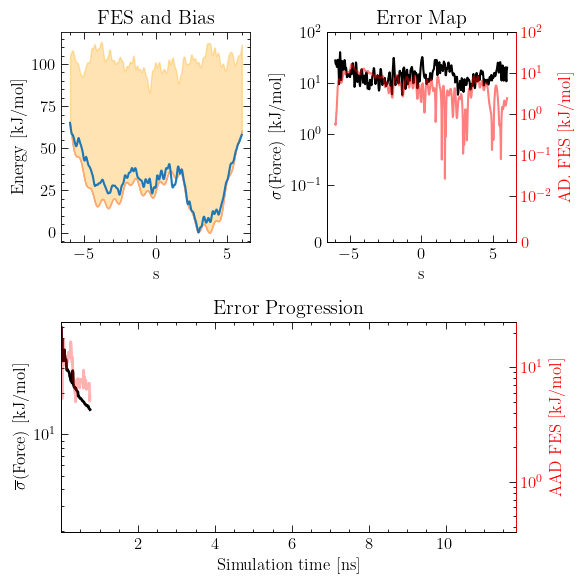

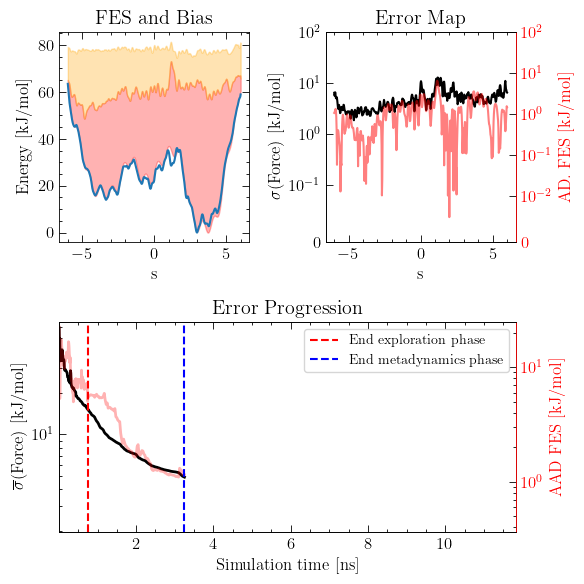

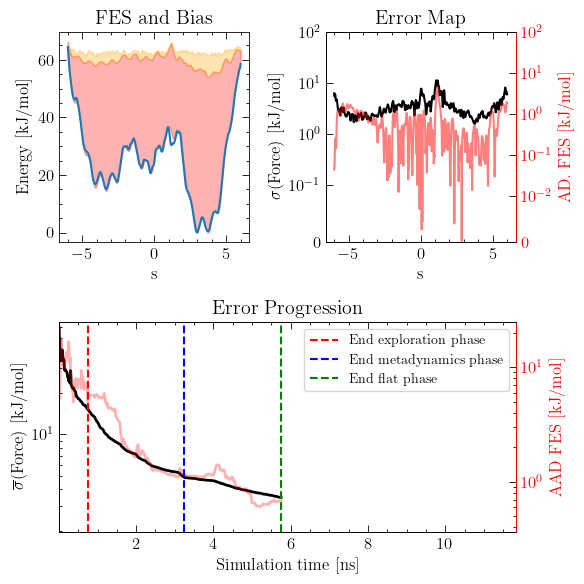

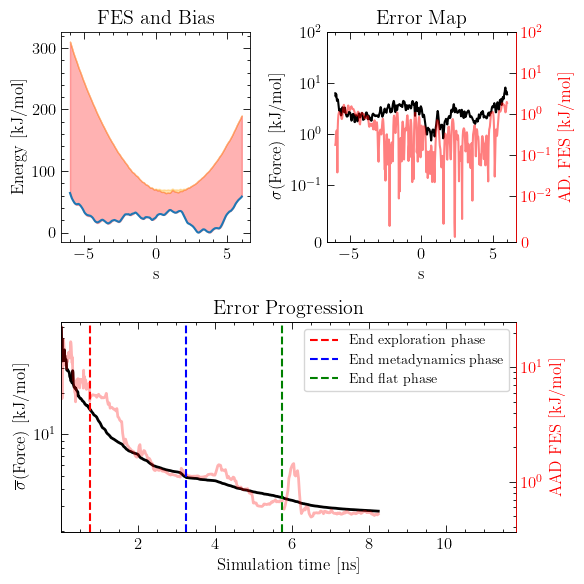

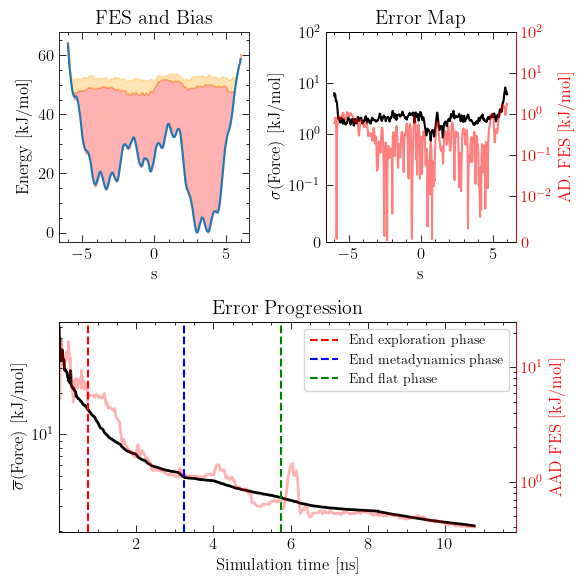

In [79]:
# #### Plot MFI1

# make_nice_figure(t_range=t_range, aofe_range=aofe_range, aad_range=aad_range)

make_nice_figure(MFI,                                                                       t_range=t_range, aofe_range=aofe_range, aad_range=aad_range)

make_nice_figure(MFI, MFI2,                   end_exploration=0, end_metad=1,               t_range=t_range, aofe_range=aofe_range, aad_range=aad_range)

make_nice_figure(MFI, MFI2, MFI3,             end_exploration=0, end_metad=1, end_flat=2,   t_range=t_range, aofe_range=aofe_range, aad_range=aad_range)

make_nice_figure(MFI, MFI2, MFI3, MFI4,       end_exploration=0, end_metad=1, end_flat=2,   t_range=t_range, aofe_range=aofe_range, aad_range=aad_range)

make_nice_figure(MFI, MFI2, MFI3, MFI4, MFI5, end_exploration=0, end_metad=1, end_flat=2,   t_range=t_range, aofe_range=aofe_range, aad_range=aad_range)


## Transition Path Bias of 2D surface (Invernizzi Potential)

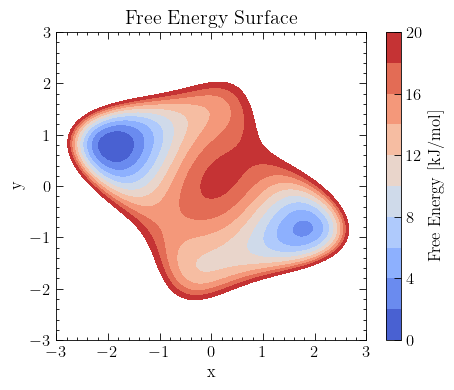

In [82]:
# Define the grid, the potential, the string of the potential and the FES cutoff
grid = np.linspace(-3, 3, 100); 
X, Y = np.meshgrid(grid, grid)
inve_pot = 1.34549*X**4+1.90211*X**3*Y+3.92705*X**2*Y**2-6.44246*X**2-1.90211*X*Y**3+5.58721*X*Y+1.33481*X+1.34549*Y**4-5.55754*Y**2+0.904586*Y+18.5598
inve_pot = inve_pot - np.min(inve_pot)
inve_pot_string = "1.34549*x^4+1.90211*x^3*y+3.92705*x^2*y^2-6.44246*x^2-1.90211*x*y^3+5.58721*x*y+1.33481*x+1.34549*y^4-5.55754*y^2+0.904586*y+18.5598"
FES_cutoff = 20

# Define plumed grid
[plX, plY, pl_min, pl_max, pl_n, pl_extra] = lib2.get_plumed_grid_2D(X, Y, [-4,-4], [4,4])

# plot the free energy surface
plt.contourf(X, Y, inve_pot, levels=np.linspace(0, FES_cutoff, 11), cmap='coolwarm'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Free Energy Surface"); plt.show()


# default parameters for the MFI class
default_params = {  "X":X, "Y":Y, "Z":inve_pot, "bw":[0.1, 0.1],
                    "plX":plX, "plY":plY, "simulation_steps":1_000_000, 
                    "position_pace":20, "n_pos_per_window":10, "metad_pace":200, "metad_width":[0.1, 0.1], "metad_height":3, "biasfactor":10,
                    "Bias_sf":1, "gaus_filter_sigma":None,
                    "FES_cutoff":FES_cutoff, # "calculate_FES_st_dev":True, "bootstrap_iter":50,
                    "record_maps":True, "record_forces_e":False, "simulation_folder_path": path_data, "ID":"", 					
                    }

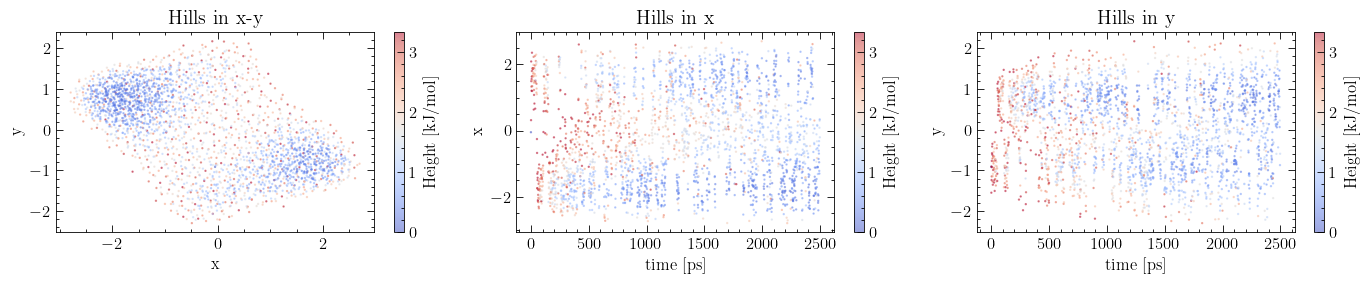

| 100% | AAD: 0.657 [kJ/mol] | Total time: 3 sec                                                            


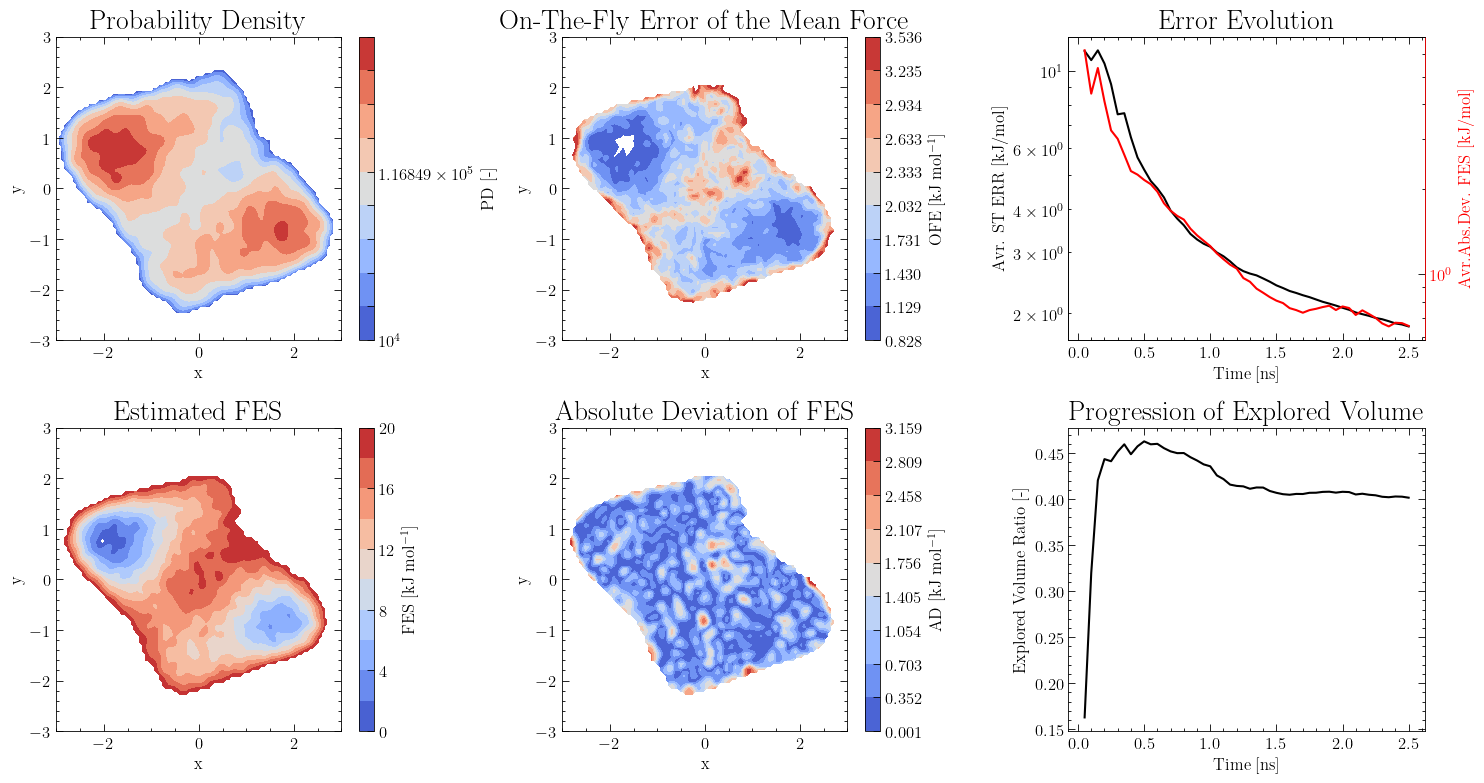

In [83]:
new_params = {**default_params}
new_params.update({"simulation_steps":500_000, "ID":"_inve"})
new_params.update({"metad_height":3, "biasfactor":10, "metad_width":[0.1, 0.1]})
# os.chdir(path_class+"simulation_folder")

MFI = MFI_class2D.MFI2D(**new_params)

# MFI.run_simulation()
# os.system("rm bck.* stats.out")

MFI.load_data(); lib2.plot_hills_trajectory(MFI.hills)

MFI.analyse_data()
t1, v1, aofe1, aad1 = MFI.Avr_Error_list[:,0], MFI.Avr_Error_list[:,1], MFI.Avr_Error_list[:,2], MFI.Avr_Error_list[:, MFI.Avr_Error_info.index("AAD")]

MFI.plot_results()


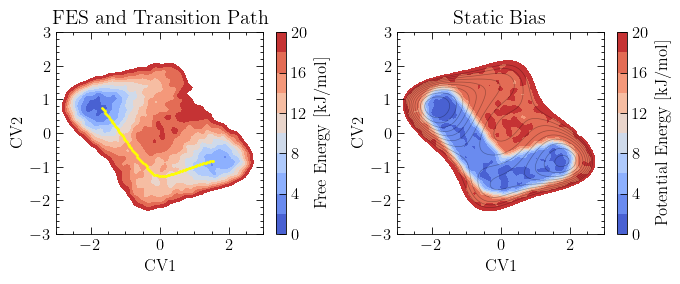

In [99]:
### test the valley surface
Z, trans_path = lib2.create_valley_surface(X, Y, FES=MFI.FES, FES_gaus_filter=5, return_path=True)#, valley_depth=10, valley_width=3/5, sharpness_exponent=6, n_images=15, n_points_interp=None, force_convergence_goal=0.2, max_steps=1000, step_size=0.03, print_info=True)

plt.figure(figsize=(7,3));

plt.subplot(1,2,1);  
plt.contourf(X, Y, MFI.FES, levels=np.linspace(0, 20, 11), cmap="coolwarm"); plt.colorbar(label="Free Energy [kJ/mol]"); 
plt.scatter(trans_path[:,0],trans_path[:,1], s=1, c='yellow')
plt.xlabel("CV1"); plt.ylabel("CV2"); plt.title("FES and Transition Path"); 

plt.subplot(1,2,2);  

biased_f =  MFI_TPB.Bias_static + MFI.Z
plt.contourf(X, Y, biased_f - np.min(biased_f), levels=np.linspace(0, 20, 11), cmap="coolwarm"); plt.colorbar(label="Potential Energy [kJ/mol]");
plt.contour(X,Y, inve_pot, levels=np.linspace(0, 20, 11), colors='black', linewidths=0.5, alpha=0.3)
plt.xlabel("CV1"); plt.ylabel("CV2"); plt.title("Static Bias"); 

plt.tight_layout(); 

plt.savefig(path_notebook + "transition_path_bias.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()




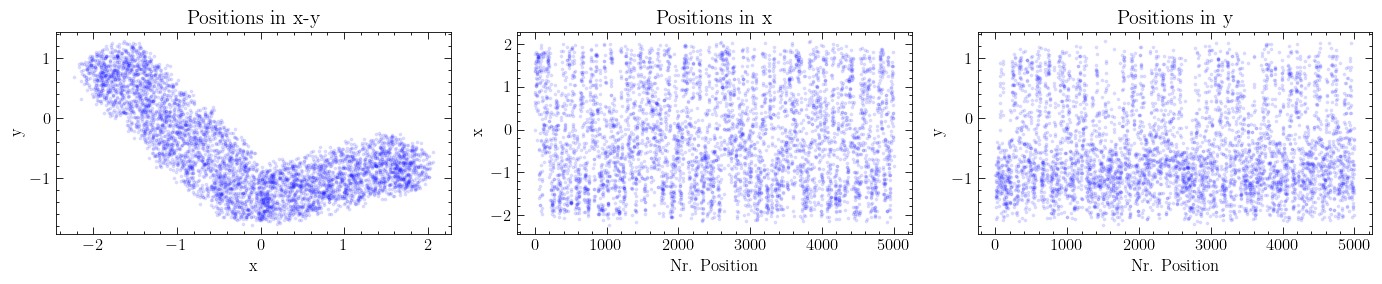

| 100% | AAD: 1.025 [kJ/mol] | Total time: 6 sec                                                            


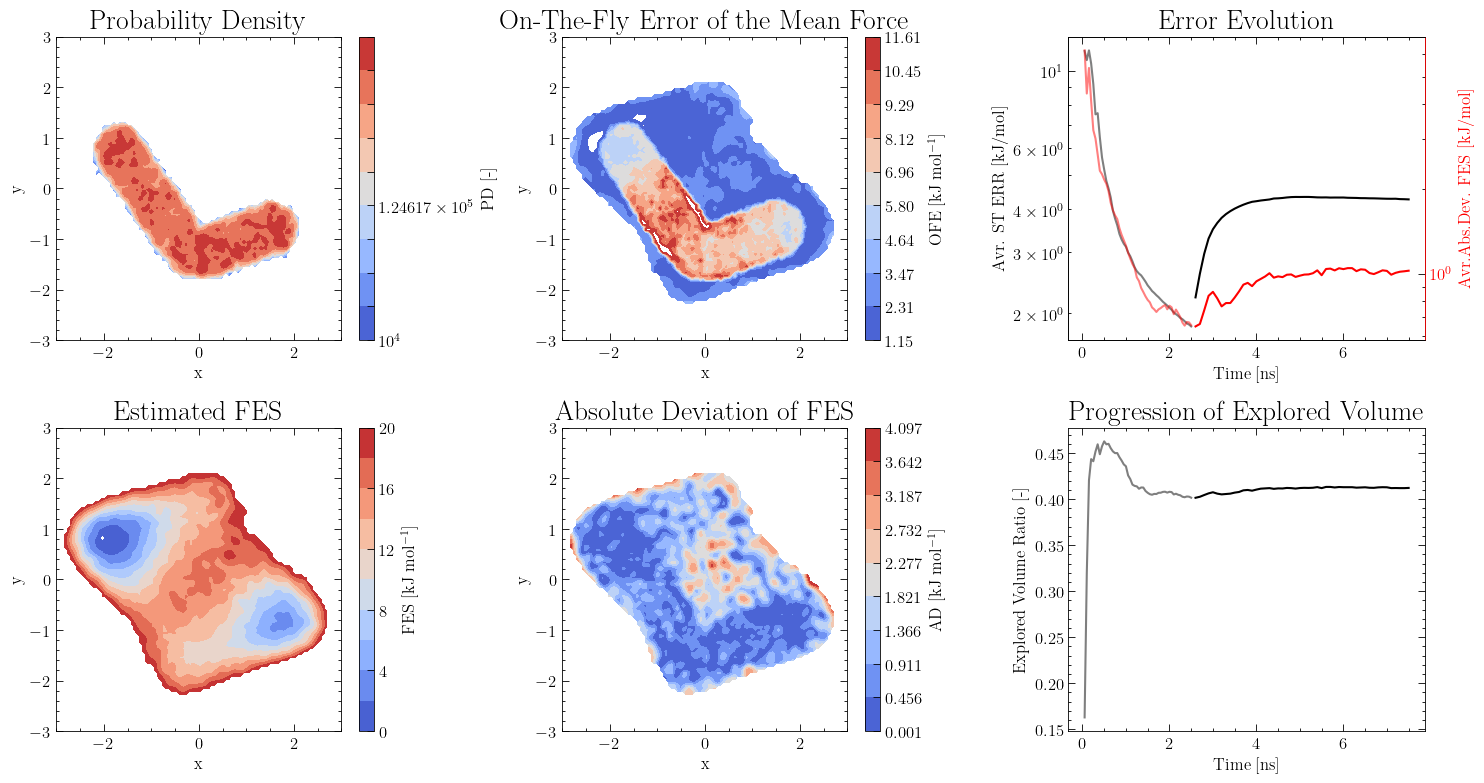

In [92]:
new_params = {**default_params}
new_params.update({"simulation_steps":1_000_000, "metad_height":0.5, "biasfactor":5, "metad_width":[0.05, 0.05]})#, "n_pos_per_hill":-1})
new_params.update({"bw":[0.02, 0.02]})
new_params.update({"initial_position":[2, -1]})
new_params.update({"Bias_sf":1, "gaus_filter_sigma":5})
new_params.update({"ID":"_inve_trans_path_bias", "base_forces":MFI.force_terms, "base_time": MFI.sim_time})

MFI_TPB = MFI_class2D.MFI2D(**new_params)

MFI_TPB.make_external_bias(FES=MFI.FES, bias_type="transition_path")

# MFI_TPB.run_simulation()
# os.system("rm bck.* stats.out")

MFI_TPB.load_position(); lib2.plot_position_trajectory(MFI_TPB.position)

MFI_TPB.analyse_data()

MFI_TPB.plot_results(more_aofe=[t1, aofe1] , more_aad = [t1, aad1], more_vol=[t1, v1])#, min_AD=0, max_AD=1, min_ofe=0, max_ofe=1)#, error_map_gaussian_filter=3)


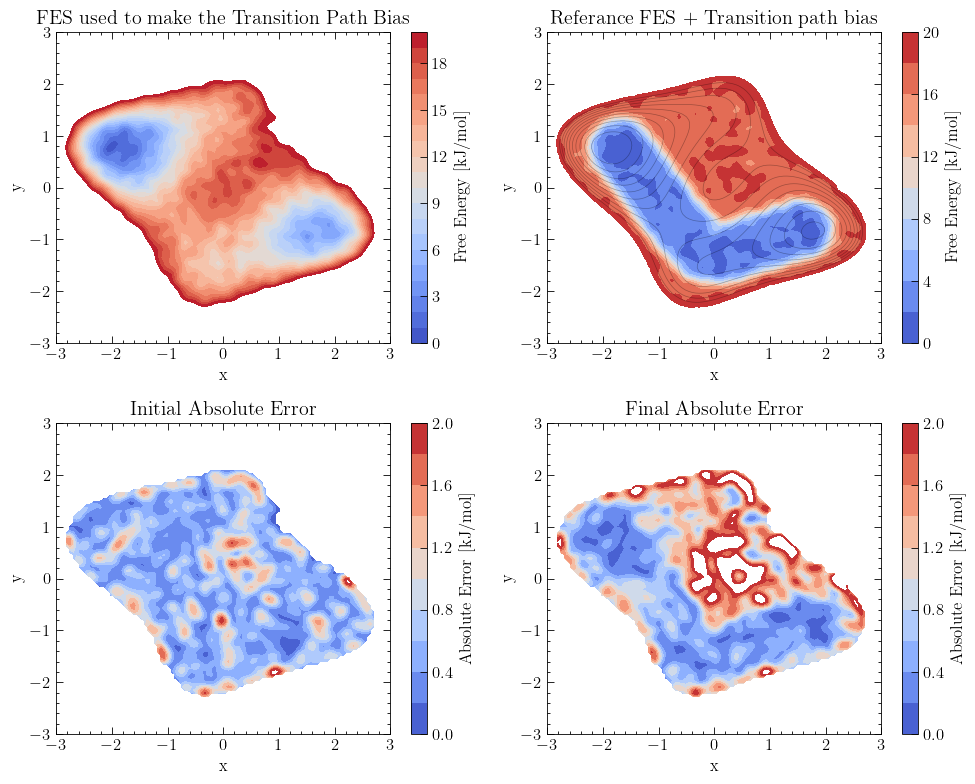

In [93]:
### Plot the results
from scipy.ndimage import gaussian_filter
gaus_filter_error_map = 1

plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.contourf(X, Y, MFI.FES, levels=np.linspace(0, 20, 21), cmap="coolwarm"); plt.colorbar(label="Free Energy [kJ/mol]"); 
plt.xlabel("x"); plt.ylabel("y"); plt.title("FES used to make the Transition Path Bias")

plt.subplot(2,2,2)
biased_f =  MFI_TPB.Bias_static + MFI.Z
plt.contourf(X, Y, biased_f - np.min(biased_f), levels=np.linspace(0, 20, 11), cmap="coolwarm"); plt.colorbar(label="Free Energy [kJ/mol]");
plt.contour(X,Y, inve_pot, levels=np.linspace(0, 20, 11), colors='black', linewidths=0.5, alpha=0.3)
plt.xlabel("x"); plt.ylabel("y"); plt.title("Referance FES + Transition path bias")

plt.subplot(2,2,3)
AD_map = lib2.zero_to_nan(gaussian_filter(MFI.AD, gaus_filter_error_map, mode="wrap") * MFI_TPB.cutoff)
plt.contourf(X, Y, AD_map, levels=np.linspace(0,2,11), cmap="coolwarm"); plt.colorbar(label="Absolute Error [kJ/mol]");
plt.xlabel("x"); plt.ylabel("y"); plt.title("Initial Absolute Error")


plt.subplot(2,2,4)
AD_map = lib2.zero_to_nan(gaussian_filter(MFI_TPB.AD, gaus_filter_error_map, mode="wrap") * MFI_TPB.cutoff)
plt.contourf(X, Y, AD_map, levels=np.linspace(0,2,11), cmap="coolwarm"); plt.colorbar(label="Absolute Error [kJ/mol]"); 
plt.xlabel("x"); plt.ylabel("y"); plt.title("Final Absolute Error")

plt.tight_layout(); plt.show()
